In [1]:
import torch
from model.unet import UNet
from model.unet_resnet import UNetResNet
from model.unet_inception import UNetInception
import numpy as np
from torch.utils.data import DataLoader
from dataset import SteelDataset
import os
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []

    def append(self, value):
        self.loss.append(
            self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss) > 0 else value)

    def get(self):
        return self.loss


class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale

        self.tic = time.time()

    def plot(self, data, name):
        if time.time() - self.tic > self.sec:
            plt.cla()

            if not isinstance(data, list):
                data = [data]

            if not isinstance(name, list):
                name = [name]

            for d, n in zip(data, name):  # 为每个数据标注对应的标签名
                if self.scale is None:
                    plt.plot(d, label=n)  # 添加标签
                elif self.scale == 'semilogx':
                    plt.semilogx(d, label=n)  # 添加标签
                elif self.scale == 'semilogy':
                    plt.semilogy(d, label=n)  # 添加标签
                elif self.scale == 'loglog':
                    plt.loglog(d, label=n)  # 添加标签
                else:
                    raise ValueError(
                        "unrecognized parameter scale {}".format(self.scale))

            plt.xlabel(self.xlabel)
            plt.ylabel(self.ylabel)
            plt.legend()  # 显示图例
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            self.tic = time.time()

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [4]:
# 设置路径
train_images_path = './data/images/all'
train_masks_path = './data/annotations/all'
train_image_files = sorted([os.path.join(train_images_path, f) for f in os.listdir(
    train_images_path) if f.endswith(('.png', '.jpg'))])
train_mask_files = sorted([os.path.join(train_masks_path, f) for f in os.listdir(
    train_masks_path) if f.endswith(('.png', '.jpg'))])

# 数据集和数据加载器
bs = 32
train_dataset = SteelDataset(train_image_files, train_mask_files, eval=False)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

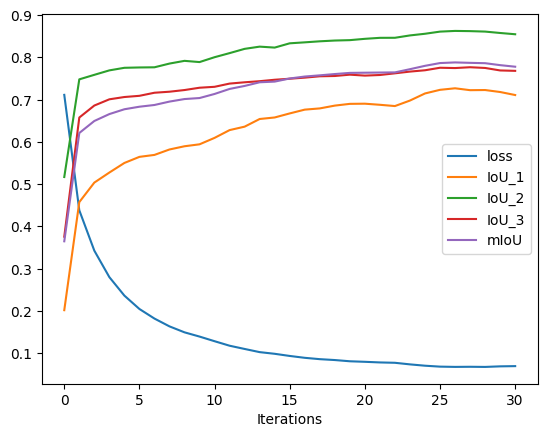

Epoch [31/50], Loss: 0.0698, mIoU: 0.7778


Epoch 32/50:  56%|█████▌    | 73/131 [00:16<00:13,  4.36it/s]


KeyboardInterrupt: 

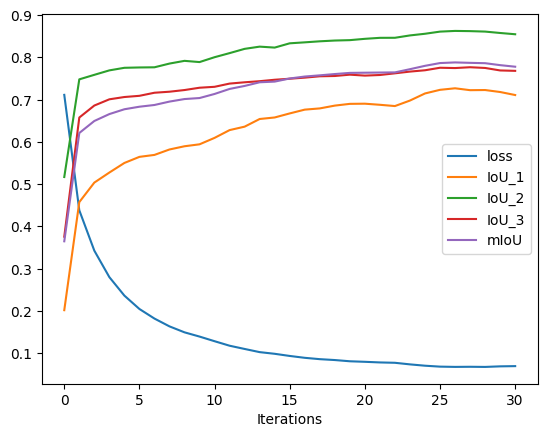

In [9]:

# 模型加载并发送至设备
model = UNetResNet().to(device)

# 输出模型参数量大小
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型参数量: {total_params / 1e6:.2f}M")

# 优化器和学习率调度器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.,2.,0.8,1.], dtype=torch.float32).to(device))


# 冻结 ResNet 编码器部分参数
for param in model.encoder0.parameters():
    param.requires_grad = False
for param in model.encoder1.parameters():
    param.requires_grad = False
for param in model.encoder2.parameters():
    param.requires_grad = False
for param in model.encoder3.parameters():
    param.requires_grad = False
for param in model.encoder4.parameters():
    param.requires_grad = False

# 初始化一些工具，用于绘图和记录历史
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='')
loss_history = LossHistory()
iou_history = [None, LossHistory(), LossHistory(), LossHistory()]
miou_history = LossHistory()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    
    # 在第10个epoch解冻 encoder3 部分
    if epoch == 10:
        for param in model.encoder3.parameters():
            param.requires_grad = True

    # 在第20个epoch解冻 encoder4 部分
    if epoch == 20:
        for param in model.encoder4.parameters():
            param.requires_grad = True

    running_loss = 0.0
    inter = {1: 0, 2: 0, 3: 0}
    union = {1: 0, 2: 0, 3: 0}

    # 训练循环
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, masks)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算 IoU
        preds = torch.argmax(outputs, dim=1)
        for i in range(images.size(0)):  # 遍历批次中的每张图像
            for j in range(1, 4):  # 分类标签 1, 2, 3
                inter[j] += ((preds[i] == j) & (masks[i] == j)).sum().item()
                union[j] += ((preds[i] == j) | (masks[i] == j)).sum().item()

    # 更新学习率调度器
    if epoch > 20:
        scheduler.step()

    # 计算并存储 IoU 和 mIoU
    for j in range(1, 4):
        iou = inter[j] / union[j] if union[j] > 0 else 0
        iou_history[j].append(iou)
    miou = sum(iou_history[j].get()[-1] for j in range(1, 4)) / 3
    miou_history.append(miou)

    # 存储损失
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)

    # 绘制当前epoch的损失和IoU
    plotter.plot([loss_history.get(), iou_history[1].get(), iou_history[2].get(), iou_history[3].get(), miou_history.get()],
                 name=['loss', 'IoU_1', 'IoU_2', 'IoU_3', 'mIoU'])

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, mIoU: {miou:.4f}")

In [6]:
torch.save(model.state_dict(), f'./saved_model/unet_inception_epoch_50.pth')